### Take a look at SPY

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from datetime import date
from dateutil.relativedelta import relativedelta

In [91]:
sns.set_style('whitegrid')

In [10]:
# read and plot SPY data

spy = pd.read_csv('../data/SPY.csv', index_col='Date', usecols=['Date', 'Adj Close'], parse_dates=True)
spy.head()

,Adj Close
Date,
2020-03-03,294.735870
2020-03-04,307.124481
2020-03-05,296.915161
2020-03-06,292.006836
2020-03-09,269.202698


In [11]:
spy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2020-03-03 to 2021-03-02
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  252 non-null    float64
dtypes: float64(1)
memory usage: 3.9 KB


In [12]:
spy.describe()

,Adj Close
count,252.000000
mean,327.938196
std,40.435925
min,220.149750
25%,300.470612
50%,332.122329
75%,361.790314
max,392.640015


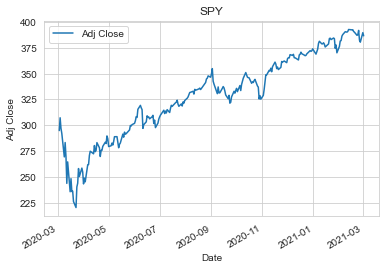

In [92]:
# plot SPY adjusted close

spy.plot()
plt.ylabel('Adj Close')
plt.title('SPY');

### Working with multiple stocks

In [74]:
def get_dates(window):
    '''
    Returns the index of date timestamps within the time window ending today
    
    Parameters:
    window (int): Number of months
    
    Returns:
    dates (index): Index of date timestamps within the time window ending today
    '''
    end_date = pd.to_datetime(date.today())
    start_date = pd.to_datetime(date.today() + relativedelta(months=-window))
    
    dates = pd.date_range(start_date, end_date)
    
    return dates

In [75]:
def get_data(symbols, window):
    '''
    Returns dataframe with adjusted closing values of the stocks specified in symbols within given time window
    
    Parameters:
    symbols (list): List of strings containing stock symbols
    window (int): Number of months
    
    Returns:
    df (dataframe): Dataframe with adjusted closing values of the stocks within specified time window
    '''

    dates = get_dates(window)
    df = pd.DataFrame(index=dates)

    # Add SPY to list of symbols if not already present. It is used as the benchmark.
    if 'SPY' not in symbols:
        symbols.insert(0, 'SPY')

    for symbol in symbols:
        df_stock = pd.read_csv('../data/{}.csv'.format(symbol), index_col='Date',
                               usecols=['Date', 'Adj Close'], parse_dates=True)
        df_stock.rename(columns={'Adj Close':symbol}, inplace=True)
        df = df.join(df_stock)
        
    df.dropna(subset=['SPY'], inplace=True)
    
    return df

In [102]:
def normalize(df):
    '''
    Returns normalized dataframe
    
    Parameters:
    df (dataframe): Dataframe
    
    Returns:
    (dataframe): Normalized dataframe
    '''
    return df / df.iloc[0]

In [111]:
def plot_data(df):
    '''
    Plots dataframe df's values
    
    Parameters:
    None
    
    Returns:
    None
    '''
    df.plot()
    plt.xlabel('Date')
    plt.ylabel('Adj Close')
    plt.title('Adj Close vs Date')

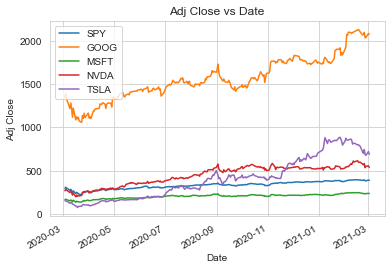

In [112]:
window = 12 # time window to look at data in months
symbols = ['GOOG', 'MSFT', 'NVDA', 'TSLA']

df = get_data(symbols, window)
plot_data(df)

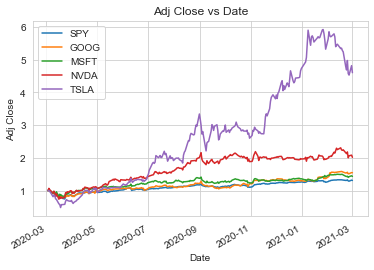

In [114]:
# look at normalized data

df_normalized = normalize(df)
plot_data(df_normalized)